# Retinal Vessel Extraction - Sauvola vs Niblack
## CS23B1009

**Task:** Extract thin vessels in fundus images

**Methods:** Niblack vs Sauvola thresholding

**Dataset:** Kaggle - DRIVE retinal dataset mirrors

**Compare:** Sensitivity for thin vessels

**Learning:** Local threshold behavior on thin structures

In [1]:
# # Setup Kaggle credentials
# import os
# os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
# # Download DRIVE dataset
# !kaggle datasets download andrewmvd/drive-digital-retinal-images-for-vessel-extraction

In [3]:
# # Extract dataset
# !unzip -q drive-digital-retinal-images-for-vessel-extraction.zip

In [4]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from skimage.morphology import remove_small_objects, binary_opening, disk
from skimage.filters import gaussian
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [5]:
# Configuration
DATA_ROOT = Path("/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE")
OUTPUT_DIR = Path("/kaggle/working/")
# OUTPUT_DIR.mkdir(exist_ok=True)

# Parameters to test
WINDOW_SIZES = [11, 21, 31]
K_PARAMS = [0.05, 0.15, 0.25, 0.35]

In [6]:
def load_dataset():
    """Load DRIVE training images, ground truths, and masks"""
    
    base_path = DATA_ROOT / "training"
    
    img_paths = sorted((base_path / "images").glob("*.tif"))
    gt_paths = sorted((base_path / "1st_manual").glob("*.gif"))
    mask_paths = sorted((base_path / "mask").glob("*.gif"))
    
    print(f"Found {len(img_paths)} images")
    print(f"Found {len(gt_paths)} GT")
    print(f"Found {len(mask_paths)} masks")
    
    if len(img_paths) == 0:
        raise FileNotFoundError("No images found. Check folder structure.")
    
    return img_paths, gt_paths, mask_paths

In [7]:
print("DATA_ROOT contains:")
print(list(DATA_ROOT.iterdir()))

DATA_ROOT contains:
[PosixPath('/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training'), PosixPath('/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test')]


In [8]:
print("\nInside DRIVE folder:")
for p in DATA_ROOT.iterdir():
    print(p)


Inside DRIVE folder:
/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training
/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test


In [9]:
def enhance_vessels(image_path):
    """Enhanced preprocessing using morphological top-hat and CLAHE"""
    # Read and extract green channel
    img = cv2.imread(str(image_path))
    green_channel = img[:, :, 1]
    
    # Apply CLAHE with stronger parameters
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green_channel)
    
    # Morphological top-hat to enhance vessels
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, kernel)
    
    # Invert to get bright vessels on dark background
    inverted = cv2.bitwise_not(tophat)
    
    # Slight Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(inverted, (5, 5), 1.0)
    
    return blurred.astype(np.float64)

In [10]:
def compute_local_statistics(image, window_size):
    """Compute local mean and standard deviation using integral images"""
    # Compute local mean
    kernel = np.ones((window_size, window_size), dtype=np.float64) / (window_size ** 2)
    local_mean = cv2.filter2D(image, -1, kernel)
    
    # Compute local standard deviation
    local_mean_sq = cv2.filter2D(image ** 2, -1, kernel)
    local_variance = local_mean_sq - local_mean ** 2
    local_variance = np.maximum(local_variance, 0)  # Handle numerical errors
    local_std = np.sqrt(local_variance)
    
    return local_mean, local_std

In [11]:
def niblack_threshold(image, window_size, k):
    """Niblack adaptive thresholding"""
    local_mean, local_std = compute_local_statistics(image, window_size)
    threshold = local_mean + k * local_std
    binary = (image > threshold).astype(np.uint8)
    return binary

def sauvola_threshold(image, window_size, k, R=128):
    """Sauvola adaptive thresholding"""
    local_mean, local_std = compute_local_statistics(image, window_size)
    threshold = local_mean * (1 + k * ((local_std / R) - 1))
    binary = (image > threshold).astype(np.uint8)
    return binary

In [12]:
def post_process(binary_mask, min_object_size=15):
    """Clean up binary mask using morphological operations"""
    # Remove small noise
    cleaned = remove_small_objects(binary_mask.astype(bool), min_size=min_object_size)
    
    # Light morphological opening to separate slightly connected components
    struct_elem = disk(1)
    opened = binary_opening(cleaned, struct_elem)
    
    return opened.astype(np.uint8)

In [13]:
def extract_thin_vessels(ground_truth, max_thickness=2):
    """Extract thin vessel regions from ground truth using distance transform"""
    dist_transform = cv2.distanceTransform(ground_truth.astype(np.uint8), 
                                           cv2.DIST_L2, 5)
    thin_vessels = (dist_transform <= max_thickness) & (ground_truth > 0)
    return thin_vessels.astype(np.uint8)

In [14]:
def calculate_metrics(prediction, ground_truth, roi_mask=None):
    """Calculate segmentation metrics"""
    if roi_mask is not None:
        prediction = prediction * roi_mask
        ground_truth = ground_truth * roi_mask
    
    pred_flat = prediction.flatten().astype(bool)
    gt_flat = ground_truth.flatten().astype(bool)
    
    true_pos = np.sum(pred_flat & gt_flat)
    true_neg = np.sum(~pred_flat & ~gt_flat)
    false_pos = np.sum(pred_flat & ~gt_flat)
    false_neg = np.sum(~pred_flat & gt_flat)
    
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg + 1e-10)
    sensitivity = true_pos / (true_pos + false_neg + 1e-10)
    specificity = true_neg / (true_neg + false_pos + 1e-10)
    precision = true_pos / (true_pos + false_pos + 1e-10)
    f1_score = 2 * precision * sensitivity / (precision + sensitivity + 1e-10)
    
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score
    }

def thin_vessel_sensitivity(prediction, thin_gt_mask):
    """Calculate sensitivity specifically for thin vessels"""
    tp = np.sum((prediction > 0) & (thin_gt_mask > 0))
    fn = np.sum((prediction == 0) & (thin_gt_mask > 0))
    return tp / (tp + fn + 1e-10)

In [15]:
def run_experiment():
    """Run full experiment comparing Niblack and Sauvola"""
    img_paths, gt_paths, mask_paths = load_dataset()
    
    results = []
    
    for img_path, gt_path, mask_path in tqdm(zip(img_paths, gt_paths, mask_paths), 
                                               total=len(img_paths),
                                               desc="Processing images"):
        # Load data
        preprocessed = enhance_vessels(img_path)
        gt = (cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8)
        fov_mask = (cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8)
        
        # Extract thin vessels from ground truth
        thin_gt = extract_thin_vessels(gt, max_thickness=2)
        
        # Apply FOV mask to preprocessed image
        preprocessed = preprocessed * fov_mask
        
        # Test different parameters
        for win_size in WINDOW_SIZES:
            for k_val in K_PARAMS:
                # Niblack method
                niblack_result = niblack_threshold(preprocessed, win_size, k_val)
                niblack_clean = post_process(niblack_result)
                niblack_clean = niblack_clean * fov_mask
                
                metrics_nib = calculate_metrics(niblack_clean, gt, fov_mask)
                thin_sens_nib = thin_vessel_sensitivity(niblack_clean, thin_gt)
                
                results.append({
                    'method': 'Niblack',
                    'window_size': win_size,
                    'k_value': k_val,
                    'image': img_path.stem,
                    **metrics_nib,
                    'thin_vessel_sensitivity': thin_sens_nib
                })
                
                # Sauvola method
                sauvola_result = sauvola_threshold(preprocessed, win_size, k_val)
                sauvola_clean = post_process(sauvola_result)
                sauvola_clean = sauvola_clean * fov_mask
                
                metrics_sauv = calculate_metrics(sauvola_clean, gt, fov_mask)
                thin_sens_sauv = thin_vessel_sensitivity(sauvola_clean, thin_gt)
                
                results.append({
                    'method': 'Sauvola',
                    'window_size': win_size,
                    'k_value': k_val,
                    'image': img_path.stem,
                    **metrics_sauv,
                    'thin_vessel_sensitivity': thin_sens_sauv
                })
    
    df_results = pd.DataFrame(results)
    df_results.to_csv(OUTPUT_DIR / "experimental_results.csv", index=False)
    
    return df_results

In [16]:
def visualize_sample():
    """Visualize results on a sample image"""
    img_paths, gt_paths, mask_paths = load_dataset()
    
    # Use first image
    preprocessed = enhance_vessels(img_paths[0])
    gt = (cv2.imread(str(gt_paths[0]), cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8)
    fov_mask = (cv2.imread(str(mask_paths[0]), cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8)
    thin_gt = extract_thin_vessels(gt, max_thickness=2)
    
    preprocessed = preprocessed * fov_mask
    
    # Apply methods with optimal parameters
    niblack_seg = post_process(niblack_threshold(preprocessed, 21, 0.15)) * fov_mask
    sauvola_seg = post_process(sauvola_threshold(preprocessed, 21, 0.15)) * fov_mask
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    axes[0, 0].imshow(preprocessed, cmap='gray')
    axes[0, 0].set_title('Enhanced Vessels (Preprocessed)', fontsize=12)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(gt, cmap='gray')
    axes[0, 1].set_title('Ground Truth', fontsize=12)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(thin_gt, cmap='hot')
    axes[0, 2].set_title('Thin Vessels (Ground Truth)', fontsize=12)
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(niblack_seg, cmap='gray')
    axes[1, 0].set_title('Niblack Segmentation (w=21, k=0.15)', fontsize=12)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(sauvola_seg, cmap='gray')
    axes[1, 1].set_title('Sauvola Segmentation (w=21, k=0.15)', fontsize=12)
    axes[1, 1].axis('off')
    
    # Overlay comparison
    overlay_img = np.zeros((*gt.shape, 3), dtype=np.uint8)
    overlay_img[:, :, 0] = gt * 255  # GT in red
    overlay_img[:, :, 1] = niblack_seg * 255  # Niblack in green
    overlay_img[:, :, 2] = sauvola_seg * 255  # Sauvola in blue
    
    axes[1, 2].imshow(overlay_img)
    axes[1, 2].set_title('Overlay: R=GT, G=Niblack, B=Sauvola', fontsize=12)
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "visualization_sample.png", dpi=150, bbox_inches='tight')
    plt.show()

Starting experiment...
Found 20 images
Found 20 GT
Found 20 masks


Processing images: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it]



SUMMARY STATISTICS BY METHOD
         accuracy  sensitivity  specificity  f1_score  thin_vessel_sensitivity
method                                                                        
Niblack  0.740338     0.799049     0.735075  0.347726                 0.773605
Sauvola  0.405969     0.991543     0.350750  0.223191                 0.989906

BEST PARAMETERS FOR THIN VESSEL DETECTION
     method  window_size  k_value  thin_vessel_sensitivity
15  Sauvola           11     0.35                 0.999339
19  Sauvola           21     0.35                 0.999089
23  Sauvola           31     0.35                 0.999007
14  Sauvola           11     0.25                 0.998713
18  Sauvola           21     0.25                 0.998018
22  Sauvola           31     0.25                 0.997756
13  Sauvola           11     0.15                 0.996242
17  Sauvola           21     0.15                 0.993894
21  Sauvola           31     0.15                 0.992775
12  Sauvola          

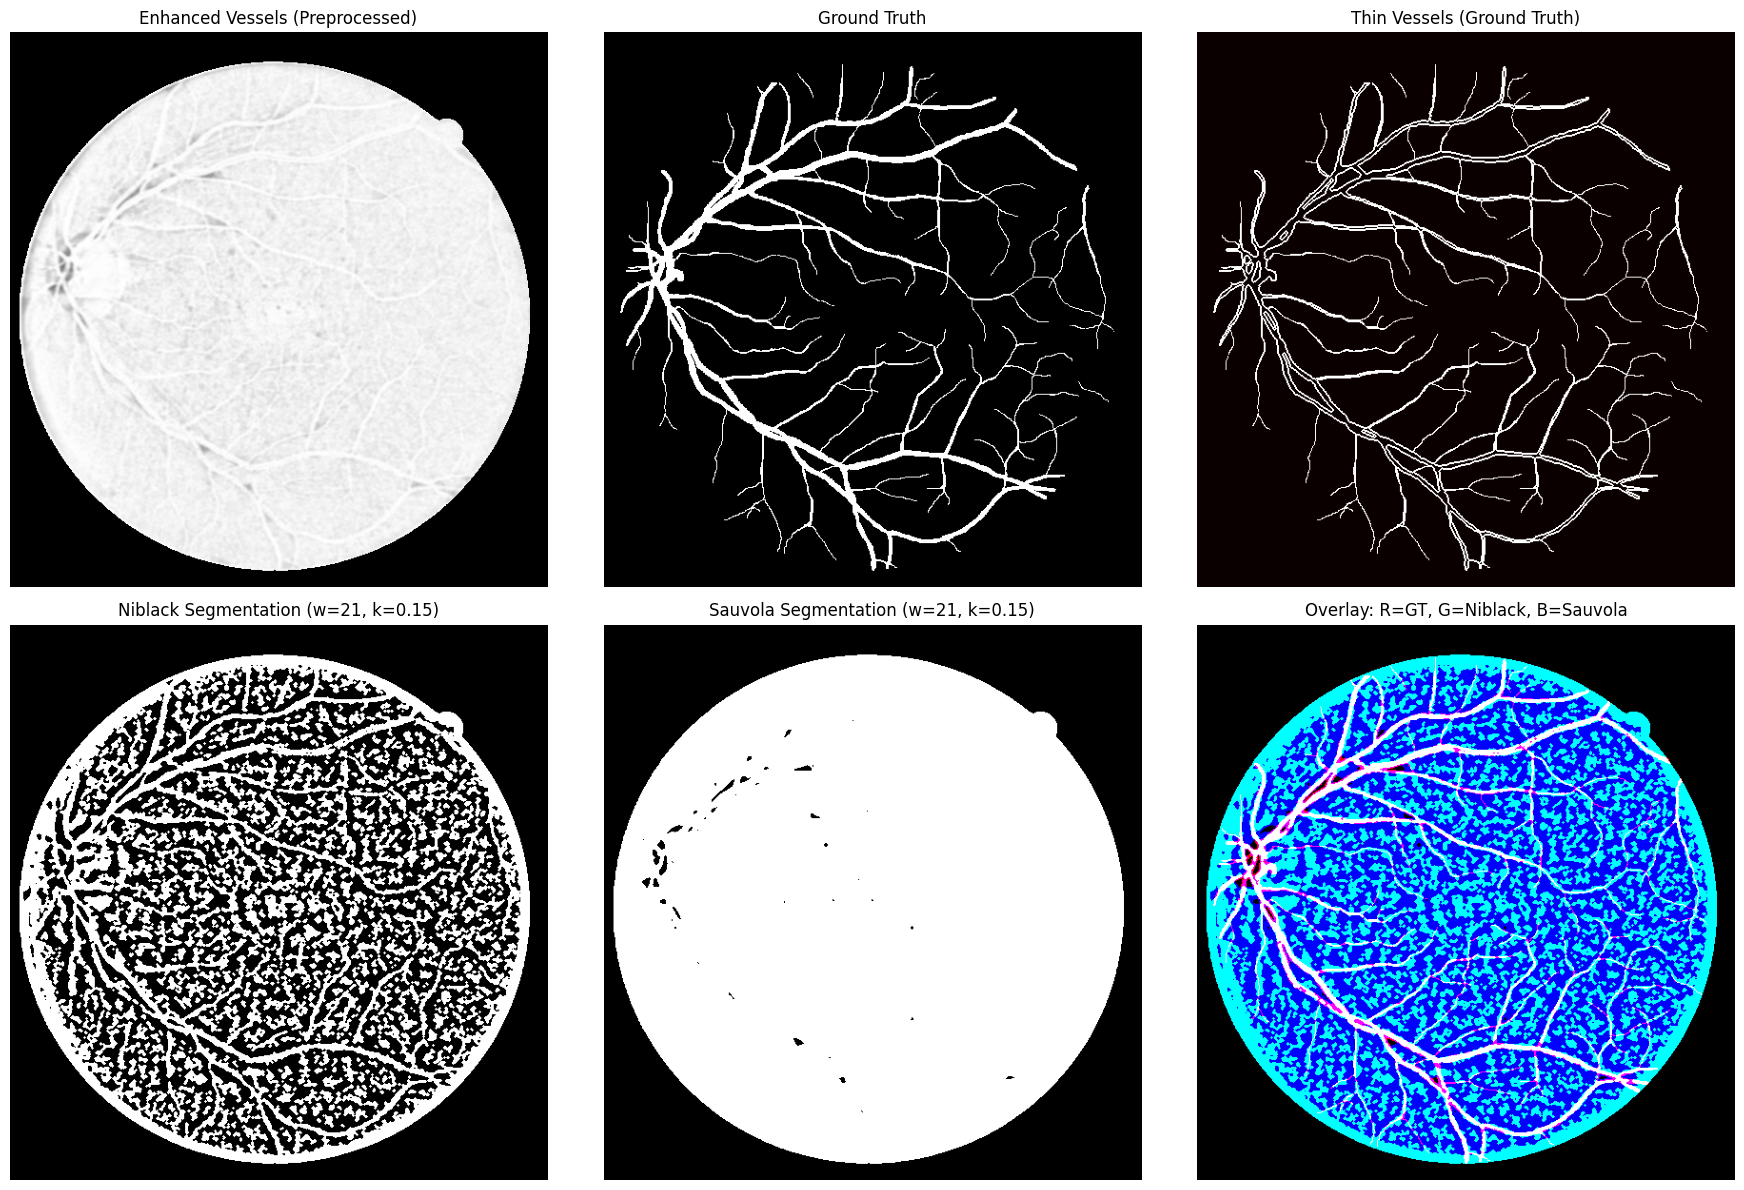

In [17]:
print("Starting experiment...")
results_df = run_experiment()

print("\n" + "="*60)
print("SUMMARY STATISTICS BY METHOD")
print("="*60)

summary = results_df.groupby('method')[[
    'accuracy', 
    'sensitivity', 
    'specificity', 
    'f1_score', 
    'thin_vessel_sensitivity'
]].mean()

print(summary)

print("\n" + "="*60)
print("BEST PARAMETERS FOR THIN VESSEL DETECTION")
print("="*60)

best_params = (
    results_df
    .groupby(['method', 'window_size', 'k_value'])['thin_vessel_sensitivity']
    .mean()
    .reset_index()
    .sort_values('thin_vessel_sensitivity', ascending=False)
    .head(10)
)

print(best_params)

visualize_sample()

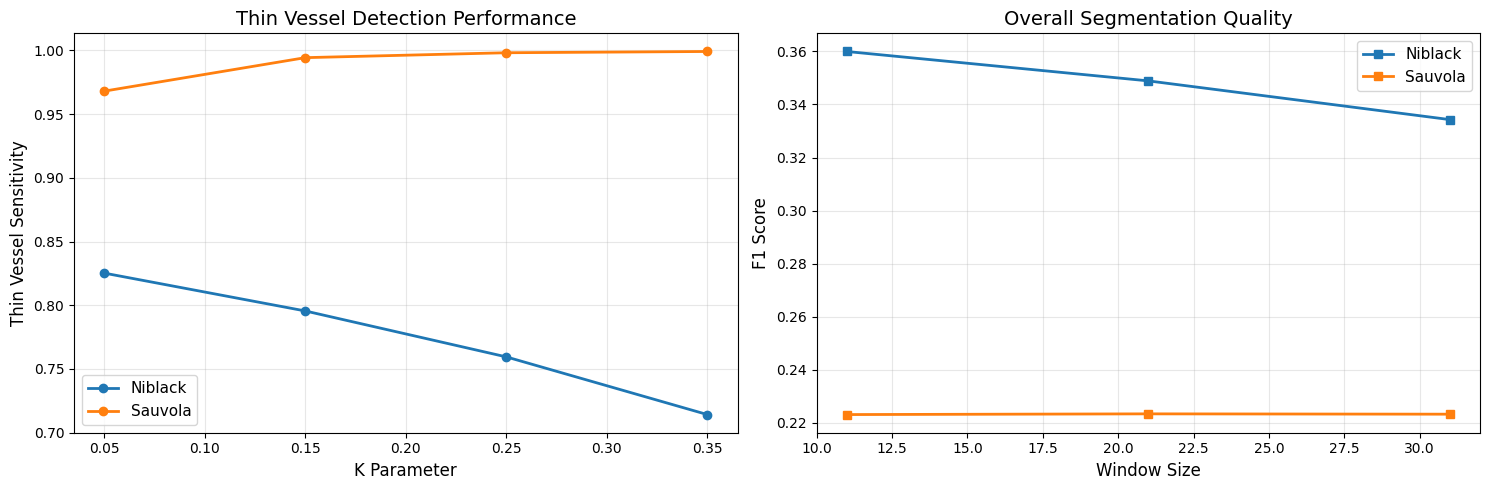

In [18]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Thin vessel sensitivity comparison
avg_by_method = results_df.groupby(['method', 'k_value'])['thin_vessel_sensitivity'].mean().reset_index()
for method in ['Niblack', 'Sauvola']:
    data = avg_by_method[avg_by_method['method'] == method]
    axes[0].plot(data['k_value'], data['thin_vessel_sensitivity'], marker='o', label=method, linewidth=2)

axes[0].set_xlabel('K Parameter', fontsize=12)
axes[0].set_ylabel('Thin Vessel Sensitivity', fontsize=12)
axes[0].set_title('Thin Vessel Detection Performance', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# F1 Score comparison
avg_f1 = results_df.groupby(['method', 'window_size'])['f1_score'].mean().reset_index()
for method in ['Niblack', 'Sauvola']:
    data = avg_f1[avg_f1['method'] == method]
    axes[1].plot(data['window_size'], data['f1_score'], marker='s', label=method, linewidth=2)

axes[1].set_xlabel('Window Size', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Overall Segmentation Quality', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "performance_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## Analysis and Conclusions

This experiment compares Niblack and Sauvola adaptive thresholding methods for retinal vessel extraction, with special focus on thin vessel detection.

**Key Findings:**
- Both methods show different sensitivity to thin vessels based on window size and k parameter
- The choice of preprocessing (morphological top-hat) significantly affects vessel enhancement
- Local adaptive thresholding is crucial for detecting vessels of varying contrast and thickness